# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import warnings 
warnings.filterwarnings('ignore')
import logging
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray import air

import torch
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Custom package #####
import pytorchGLM as pglm
from pytorchGLM.main.training import train_network



# Format Data

## Loading  Niell lab Raw Data

In [5]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] #,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['free_move']       = True
args['train_shifter']   = True
args['Nepochs']         = 10000

ModelID = 1
params, file_dict, exp = pglm.load_params(args,ModelID,file_dict=None,exp_dir_name=None,nKfold=0,debug=False)


In [17]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
params = pglm.get_modeltype(params)
train_dataset, test_dataset, network_config = pglm.load_datasets(file_dict,params,single_trial=True)


Tot_units: (128,)
Good_units: (108,)


In [16]:
x,xpos,y = train_dataset[:10]
print(x.shape,xpos.shape,y.shape)

torch.Size([10, 5, 30, 40]) torch.Size([10, 3]) torch.Size([10, 108])


## Custom Dataset Formatting Base Model

In [25]:
args = pglm.arg_parser(jupyter=True)
args

{'date_ani': '070921/J553RT',
 'base_dir': '~/Research/SensoryMotorPred_Data/Testing',
 'fig_dir': '~/Research/SensoryMotorPred_Data/FigTesting',
 'data_dir': '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/',
 'model_dt': 0.05,
 'ds_vid': 4,
 'Kfold': 0,
 'ModRun': '1',
 'Nepochs': 10,
 'load_ray': False,
 'do_norm': True,
 'crop_input': True,
 'free_move': True,
 'thresh_cells': True,
 'fm_dark': False,
 'NoL1': False,
 'NoL2': False,
 'NoShifter': False,
 'do_shuffle': False,
 'use_spdpup': False,
 'only_spdpup': False,
 'train_shifter': False,
 'shifter_5050': False,
 'shifter_5050_run': False,
 'EyeHead_only': False,
 'EyeHead_only_run': False,
 'SimRF': False}

In [26]:

def load_BaseModel_params(args,exp_dir_name='Testing',ModelID=0,nKfold=0,debug=False):
    """ Load parameter dictionary for custom BaseModel network.

    Args:
        args (dict): Argument dictionary 
        exp_dir_name (str): name of experiment. 
        ModelID (int, optional): Model Identification number. Defaults to 0.
        exp_dir_name (str, optional): Optional experiment directory name if using own data. Defaults to None.
        nKfold (int, optional): Kfold number for versioning. Defaults to 0.
        debug (bool, optional): debug=True does not create experiment directories. Defaults to False.

    Returns:
        params (dict): dictionary of parameters
        exp (obj): Test_tube object for organizing files and tensorboard
    """
    import yaml
    from pathlib import Path
    from test_tube import Experiment
    
    ##### Create directories and paths #####
    date_ani2 = '_'.join(args['date_ani'].split('/'))
    data_dir = Path(args['data_dir']).expanduser() / args['date_ani'] / args['stim_cond'] 
    base_dir = Path(args['base_dir']).expanduser()
    save_dir = (base_dir / args['date_ani'] / args['stim_cond'])
    save_dir.mkdir(parents=True, exist_ok=True)
    base_dir.mkdir(parents=True, exist_ok=True)

    ##### Set up test_tube versioning #####
    exp = Experiment(name='ModelID{}'.format(ModelID),
                        save_dir=save_dir / exp_dir_name, 
                        debug=debug,
                        version=nKfold)

    save_model = exp.save_dir / exp.name / 'version_{}'.format(nKfold)

    params = {
        ##### Data Parameters #####
        'data_dir':                 data_dir,
        'base_dir':                 base_dir,
        'exp_name_base':            base_dir.name,
        'stim_cond':                args['stim_cond'],
        'save_dir':                 save_dir,
        'exp_name':                 exp.save_dir.name,
        'save_model':               save_model,
        'date_ani2':                date_ani2,
        'model_dt':                 args['model_dt'],
        ##### Model Parameters #####
        'ModelID':                  ModelID,
        'lag_list':                 [0], # List of which timesteps to include in model fit
        'Nepochs':                  args['Nepochs'],
        'Kfold':                    args['Kfold'],
        'NoL1':                     args['NoL1'],
        'NoL2':                     args['NoL2'],
        'train_shifter':            False,
        'model_type':               'pytorchGLM_custom', # For naming files
    }

    params['nt_glm_lag']=len(params['lag_list']) # number of timesteps for model fits
    params['data_name'] = '_'.join([params['date_ani2'],params['stim_cond']])
    
    ##### Saves yaml of parameters #####
    if debug==False:
        params2=params.copy()
        for key in params2.keys():
            if isinstance(params2[key], Path):
                params2[key]=params2[key].as_posix()

        pfile_path = save_model / 'model_params.yaml'
        with open(pfile_path, 'w') as file:
            doc = yaml.dump(params2, file, sort_keys=True)

    return params, exp


In [90]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = '~/Research/SensoryMotorPred_Data/Testing'
args['fig_dir']         = '~/Research/SensoryMotorPred_Data/FigTesting'
args['data_dir']        = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = True
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

In [91]:
from sklearn.gaussian_process.kernels import RBF

seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

def initialize_GP_inputs(Npats,length_scale,batch_size,Nx_low,Nx,Ny_star,Nr,seed=42,multi_input=False,pytorch=True):
    
    ##### Set random seed #####
    np.random.seed(seed+1)
    torch.manual_seed(seed+1)
    ##### Initialize RBF kernels #####
    rbf = RBF(length_scale=length_scale)
    genX = np.arange(Npats)[:,np.newaxis]
    genY = np.arange(Npats)[:,np.newaxis]
    Kx = rbf(genX,genX)
    Ky = rbf(genY,genY)
    if multi_input:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_low1 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x0 = torch.bmm(x_low0,x_expand)
        x1 = torch.bmm(x_low1,x_expand)
        x_all = torch.stack((x0,x1),dim=1).float()
        ##### Initialize target patterns #####
        y_all = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Ny_star,Nr))),3,2)
        y_all = ((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1,1))
    else:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x_all = torch.bmm(x_low0,x_expand)
        ##### Initialize target patterns #####
        y_all = torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Nr)))
        y_all = torch.transpose((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1),-1,-2)

    if pytorch:
        x_all = x_all.float()
        y_all = y_all.float()
    else:
        x_all = x_all.float().numpy()
        y_all = y_all.float().numpy()

    return x_all, y_all


In [115]:
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=3,batch_size=1,Nx_low=2,Nx=10,Ny_star=2,Nr=5,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = x_all/torch.max(torch.abs(x_all))
xtr,xte = x_all[:750], x_all[750:]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[:750], y_all[750:]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)
params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
train_dataset = pglm.FreeMovingEphysDataset(xtr,xtr_pos,ytr)
test_dataset = pglm.FreeMovingEphysDataset(xte,xte_pos,yte)


X: torch.Size([750, 10]) Xpos: torch.Size([750, 10]) y: torch.Size([750, 5])
X: torch.Size([250, 10]) Xpos: torch.Size([250, 10]) y: torch.Size([250, 5])


In [116]:
network_config = pglm.make_network_config(params,single_trial=0,custom=True)
network_config['lr_w'] = .05
network_config['lr_b'] = .05

In [117]:
tloss_trace,vloss_trace,model,optimizer = train_network(network_config, params=params,train_dataset=train_dataset,test_dataset=test_dataset,filename=None,meanbias=None)

  0%|          | 0/50 [00:00<?, ?it/s]

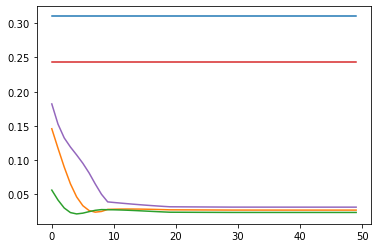

In [118]:
plt.plot(vloss_trace)

In [120]:
yhat = model(xte.to(device),xte_pos.to(device)).detach().cpu().numpy().squeeze()
yt = yte.cpu().detach().numpy().squeeze()
# plt.imshow(np.corrcoef(yhat.T,yt.T))
np.corrcoef(yhat[:,1],yt[:,1])

array([[1.        , 0.07154684],
       [0.07154684, 1.        ]])

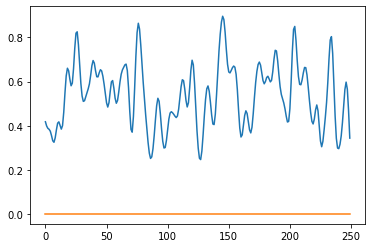

In [121]:
plt.plot(yte[:,0])
plt.plot(yhat[:,0])

In [99]:
from sklearn.linear_model import LinearRegression
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=3,batch_size=1,Nx_low=2,Nx=10,Ny_star=2,Nr=5,pytorch=False)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = x_all/np.max(np.abs(x_all))
xtr,xte = x_all[:750], x_all[750:]
xtr_pos,xte_pos = np.zeros_like(xtr),np.zeros_like(xte)
ytr,yte = y_all[:750], y_all[750:]

l1 = LinearRegression()
l1.fit(xtr,ytr)
yhat = l1.predict(xte)
np.corrcoef(yhat[:,0],yte[:,0])

array([[ 1.        , -0.03637109],
       [-0.03637109,  1.        ]])

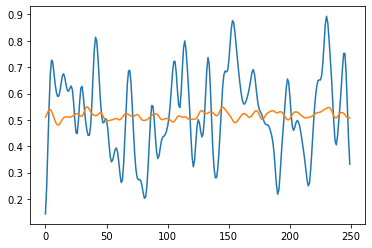

In [101]:
plt.plot(yte[:,1])
plt.plot(yhat[:,1])

In [40]:
from pytorchGLM.main.models import BaseModel,model_wrapper
from torch.utils.data import DataLoader


In [46]:
model = model_wrapper((network_config,BaseModel))

model.to(device)
for p in model.Cell_NN[0].parameters():
    print(p)
optimizer, scheduler = pglm.setup_model_training(model,params,network_config)
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=2, pin_memory=True,)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset),  num_workers=2, pin_memory=True,)
tloss_trace = torch.zeros((params['Nepochs'], network_config['Ncells']), dtype=torch.float)

if network_config['single_trial'] is not None:
    pbar = pglm.tqdm((range(params['Nepochs'])))
else: 
    pbar = (range(params['Nepochs']))  
for epoch in pbar:  # loop over the dataset multiple times
    for i, minibatch in enumerate(train_dataloader, 0):
        # get the inputs; minibatch is a list of [vid, pos, y]
        vid,pos,y = minibatch
        vid,pos,y = vid.to(device),pos.to(device),y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(vid,pos)
        loss = model.loss(outputs, y)
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        tloss_trace[epoch] = loss.detach().cpu()

Parameter containing:
tensor([[-5.0009e-07, -8.1743e-07,  2.1945e-08, -4.8368e-07,  6.3098e-07,
         -5.1876e-07,  1.0562e-07, -8.7499e-07, -2.9799e-09,  8.7674e-07],
        [ 5.3007e-07,  4.2272e-07, -5.8745e-07,  8.5477e-07, -4.9860e-07,
          9.1934e-07, -8.2605e-07, -4.9342e-07, -3.0445e-07,  1.6749e-07],
        [ 5.4363e-07,  2.1383e-07, -3.7437e-07, -7.9645e-07, -2.9261e-07,
         -4.7353e-07, -6.0321e-07,  6.2032e-07,  1.3948e-07, -5.3749e-07],
        [ 4.7595e-07, -6.7444e-07, -5.8802e-07, -9.6871e-08,  6.5612e-07,
          5.1065e-07, -6.7472e-07, -7.0537e-07,  3.3628e-07, -7.2493e-08],
        [ 1.0281e-07,  2.8479e-08, -7.1590e-07, -1.6872e-07, -3.1956e-07,
         -1.7290e-07,  6.2878e-07, -9.3838e-07,  9.1077e-08,  9.8039e-07]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.2847, -0.2718,  0.0555,  0.2295,  0.2289], device='cuda:0',
       requires_grad=True)


  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
tloss_trace

tensor([[0.0638, 0.2985, 0.2120, 0.0929, 0.0895],
        [0.0596, 0.2985, 0.2017, 0.0868, 0.0837],
        [0.0556, 0.2985, 0.1921, 0.0813, 0.0785],
        [0.0518, 0.2985, 0.1830, 0.0764, 0.0739],
        [0.0482, 0.2985, 0.1741, 0.0720, 0.0697],
        [0.0448, 0.2985, 0.1658, 0.0677, 0.0657],
        [0.0416, 0.2985, 0.1579, 0.0636, 0.0620],
        [0.0387, 0.2985, 0.1506, 0.0597, 0.0584],
        [0.0359, 0.2985, 0.1437, 0.0559, 0.0551],
        [0.0334, 0.2985, 0.1372, 0.0523, 0.0519],
        [0.0311, 0.2985, 0.1313, 0.0489, 0.0490],
        [0.0290, 0.2985, 0.1260, 0.0458, 0.0463],
        [0.0271, 0.2985, 0.1211, 0.0429, 0.0438],
        [0.0254, 0.2985, 0.1167, 0.0402, 0.0415],
        [0.0238, 0.2985, 0.1127, 0.0378, 0.0393],
        [0.0225, 0.2985, 0.1091, 0.0355, 0.0374],
        [0.0213, 0.2985, 0.1057, 0.0334, 0.0356],
        [0.0203, 0.2985, 0.1026, 0.0315, 0.0340],
        [0.0195, 0.2985, 0.0995, 0.0297, 0.0326],
        [0.0188, 0.2985, 0.0965, 0.0282, 0.0314]])

In [48]:
for p in model.Cell_NN[0].parameters():
    print(p)

Parameter containing:
tensor([[ 1.6907e-02, -9.7285e-04,  1.2513e-03,  1.9897e-02, -1.0934e-02,
          1.5800e-02, -2.3851e-02, -2.0874e-02, -1.9836e-02,  1.2443e-02],
        [ 5.3007e-07,  4.2272e-07, -5.8745e-07,  8.5477e-07, -4.9860e-07,
          9.1934e-07, -8.2605e-07, -4.9342e-07, -3.0445e-07,  1.6749e-07],
        [-1.4449e-01, -2.5916e-02, -6.7773e-03, -1.3821e-01,  1.5696e-01,
         -1.4694e-01,  1.2372e-01,  1.3600e-01,  1.3831e-01, -1.5356e-01],
        [-1.1203e-02,  1.8580e-02, -1.7263e-02, -1.1014e-02,  5.4900e-03,
         -1.1162e-02,  1.1334e-02,  1.0994e-02,  1.1020e-02, -9.2893e-03],
        [-1.2248e-02,  3.6067e-02, -3.4728e-02, -1.7090e-02, -3.0198e-02,
         -8.7286e-03,  2.2987e-02,  1.8236e-02,  1.7036e-02,  1.2285e-02]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.4653, -0.2718,  0.2413,  0.4152,  0.4128], device='cuda:0',
       requires_grad=True)


# Ray Tune Training: Parallel Cross Validation

In [ ]:

sync_config = tune.SyncConfig()  # the default mode is to use use rsync
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_network,params=params,train_dataset=train_dataset,test_dataset=test_dataset),
        resources={"cpu": 2, "gpu": .5}),
    tune_config=tune.TuneConfig(metric="avg_loss",mode="min",),
    param_space=network_config,
    run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config,verbose=2)
)
results = tuner.fit()

best_result = results.get_best_result("avg_loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
df = results.get_dataframe()
best_network = list(params['save_model'].glob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]
pglm.h5store(params['save_model'] / 'NetworkAnalysis/experiment_data.h5', df, **{'best_network':best_network})